<a href="https://colab.research.google.com/github/iam-omwenga/SmartAlgo---AI-Powered-Stock-Trading-Strategy/blob/main/smartalgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Model Accuracy: 0.48


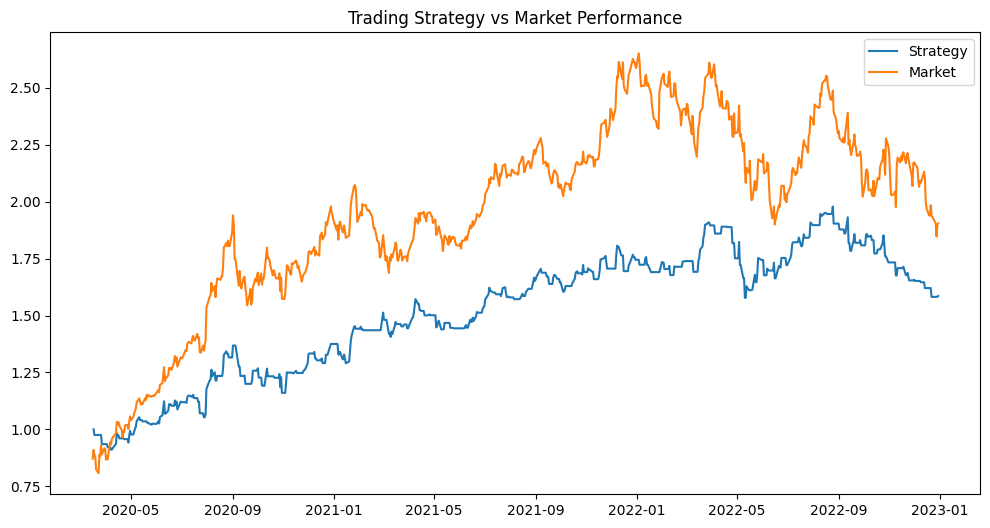

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Fetch historical stock data
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    # Check if 'Adj Close' exists, if not, use 'Close'
    if 'Adj Close' in data.columns:
        data['Return'] = data['Adj Close'].pct_change()
    else:
        data['Return'] = data['Close'].pct_change()
    data['Direction'] = np.where(data['Return'] > 0, 1, 0)
    return data.dropna()

# Feature engineering
def generate_features(data):
    # Check if 'Adj Close' exists, if not, use 'Close'
    close_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    data['SMA_10'] = data[close_col].rolling(window=10).mean()
    data['SMA_50'] = data[close_col].rolling(window=50).mean()
    data['Volatility'] = data['Return'].rolling(window=10).std()
    return data.dropna()

# Train a model
def train_model(data):
    features = ['SMA_10', 'SMA_50', 'Volatility']
    X = data[features]
    y = data['Direction']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Model Accuracy: {accuracy:.2f}')
    return model, scaler

# Trading strategy simulation
def backtest_strategy(data, model, scaler):
    features = ['SMA_10', 'SMA_50', 'Volatility']
    X = data[features]
    X_scaled = scaler.transform(X)
    data['Signal'] = model.predict(X_scaled)

    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()
    data['Cumulative_Market'] = (1 + data['Return']).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Cumulative_Strategy'], label='Strategy')
    plt.plot(data.index, data['Cumulative_Market'], label='Market')
    plt.legend()
    plt.title("Trading Strategy vs Market Performance")
    plt.show()

# Run the algorithm
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-01-01"

stock_data = fetch_data(ticker, start_date, end_date)
stock_data = generate_features(stock_data)
trading_model, data_scaler = train_model(stock_data)
backtest_strategy(stock_data, trading_model, data_scaler)
